In [ ]:
# Prompt Engineering Playground

This notebook demonstrates various prompting techniques including:
- **Zero-shot prompting**: Direct instructions with no examples
- **Few-shot prompting**: Including examples to guide the model
- **Chain-of-thought prompting**: Encouraging step-by-step reasoning

These techniques are applied to diverse tasks:
- Arithmetic problems
- Text rephrasing
- Content summarization
- Classification tasks

## Setup Requirements

1. Make sure you have a `.env` file with your `GEMINI_API_KEY`
2. Install required packages using the cell below
3. Restart the kernel if needed after installing packages


In [20]:
# Install required packages
%pip install google-genai python-dotenv pandas matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install openai

import os
import json
import time
from typing import Dict, List, Union, Optional
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Import Gemini API
from google import genai
from google.genai import types
from google.genai.errors import ServerError

# Debug: Check current working directory
print(f"Current working directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")

# Load environment variables
try:
    from dotenv import load_dotenv
    # Try to load from multiple possible locations
    env_loaded = load_dotenv()  # Load from current directory
    if not env_loaded:
        env_loaded = load_dotenv('../.env')  # Try parent directory
    if not env_loaded:
        env_loaded = load_dotenv('.env')  # Try explicit .env file
    print(f"✓ dotenv loaded successfully (found: {env_loaded})")
except ImportError:
    print("⚠️ dotenv not installed. Using environment variables directly.")

# Check for .env file in current directory
if os.path.exists('.env'):
    print("✓ .env file found in current directory")
    with open('.env', 'r') as f:
        content = f.read()
        print(f"✓ .env file content: {content[:50]}...")
else:
    print("❌ .env file not found in current directory")
    # Let's try to set the API key directly for now
    print("✓ API key set directly from script")

# Initialize the Gemini client
gemini_api_key = os.environ.get("GEMINI_API_KEY")
client = None  # Global client variable

print(f"API key check: {'Found' if gemini_api_key else 'Not found'}")
if gemini_api_key:
    print(f"API key preview: {gemini_api_key[:10]}...{gemini_api_key[-4:]}")

if not gemini_api_key:
    print("❌ Warning: GEMINI_API_KEY not found in environment variables.")
    print("Please set your API key in a .env file or environment variable.")
    print("Example .env file content: GEMINI_API_KEY=your_actual_api_key_here")
else:
    try:
        client = genai.Client(api_key=gemini_api_key)
        print("✓ Gemini client initialized successfully.")
    except Exception as e:
        print(f"❌ Error initializing Gemini client: {e}")
        print("API calls will likely fail.")

# Function to handle API calls with retry logic
def get_completion(
    prompt: str, 
    model: str = "gemini-2.0-flash",
    temperature: float = 0,
    max_retries: int = 3,
    retry_delay: int = 2
) -> str:
    """
    Send a prompt to the Gemini API and get a completion.
    
    Args:
        prompt: The prompt to send to the API
        model: The model to use (e.g., "gemini-2.0-flash", "gemini-1.5-flash")
        temperature: Controls randomness (0=deterministic, 1=creative)
        max_retries: Maximum number of retry attempts
        retry_delay: Delay between retries in seconds
        
    Returns:
        The completion text
    """
    if client is None:
        return "❌ Error: Gemini client is not initialized. Check GEMINI_API_KEY."
    
    contents = [
        types.Content(
            role="user",
            parts=[types.Part.from_text(text=prompt)],
        ),
    ]
    
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
        temperature=temperature,
    )
    
    for attempt in range(max_retries):
        try:
            response_text = ""
            for chunk in client.models.generate_content_stream(
                model=model,
                contents=contents,
                config=generate_content_config,
            ):
                response_text += chunk.text
            return response_text
            
        except ServerError as e:
            if e.status_code == 503 and attempt < max_retries - 1:
                print(f"⚠️ Server overloaded (503). Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retry_delay *= 2  # Exponential backoff
            else:
                return f"❌ Failed after {max_retries} attempts: {e}"
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"⚠️ Error: {e}. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                return f"❌ Error: Could not get completion from API: {e}"

if client:
    print("\n🚀 Setup complete! Gemini client is ready for prompt engineering.")
    # Test the connection
    test_response = get_completion("Say hello in one word.")
    print(f"✓ Test API call successful: {test_response}")
else:
    print("\n❌ Setup incomplete. Please configure your GEMINI_API_KEY.")



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Current working directory: /workspaces/GenAI-developer-upskilling-track
Files in current directory: ['week_one', 'week_three', 'week_one_sdk', '.git', 'week_two', '.gitignore']
✓ dotenv loaded successfully (found: False)
❌ .env file not found in current directory
✓ API key set directly from script
API key check: Found
API key preview: AIzaSyBNYy...lXEs
✓ Gemini client initialized successfully.

🚀 Setup complete! Gemini client is ready for prompt engineering.
Note: you may need to restart the kernel to use updated packages.
Current working directory: /workspaces/GenAI-developer-upskilling-track
Files in current directory: ['week_one', 'week_three', 'week_one_sdk', '.git', 'week_

In [9]:
class PromptTemplate:
    def __init__(
        self, 
        template: str, 
        input_variables: List[str] = None,
        template_type: str = "zero-shot"
    ):
        """
        Initialize a prompt template.
        
        Args:
            template: The template string with placeholders for variables
            input_variables: List of variable names in the template
            template_type: Type of prompt (zero-shot, few-shot, chain-of-thought)
        """
        self.template = template
        self.input_variables = input_variables or []
        self.template_type = template_type
        self.results = []
        
    def format(self, **kwargs) -> str:
        """
        Format the template with the given variables.
        
        Args:
            **kwargs: The variables to substitute into the template
            
        Returns:
            The formatted prompt
        """
        # Validate that all required variables are provided
        for var in self.input_variables:
            if var not in kwargs:
                raise ValueError(f"Missing required variable: {var}")
        
        # Format the template
        return self.template.format(**kwargs)
    
    def run(
        self, 
        model: str = "gemini-2.0-flash", 
        temperature: float = 0,
        **kwargs
    ) -> str:
        """
        Format the template and get a completion.
        
        Args:
            model: The model to use for completion
            temperature: Controls randomness
            **kwargs: The variables to substitute into the template
            
        Returns:
            The model's response
        """
        prompt = self.format(**kwargs)
        response = get_completion(prompt, model=model, temperature=temperature)
        
        # Log the result
        self.results.append({
            "prompt": prompt,
            "response": response,
            "model": model,
            "temperature": temperature,
            "variables": kwargs
        })
        
        return response
    
    def get_results_df(self) -> pd.DataFrame:
        """
        Return the results as a DataFrame.
        
        Returns:
            DataFrame containing all results
        """
        return pd.DataFrame(self.results)

# Dictionary to store and compare different prompt templates
prompt_templates = {}


In [11]:
def evaluate_prompts(
    templates: Dict[str, PromptTemplate], 
    eval_data: List[Dict],
    metrics: List[str] = ["correctness", "relevance", "clarity"]
) -> pd.DataFrame:
    """
    Evaluate multiple prompt templates on the same evaluation data.
    
    Args:
        templates: Dictionary of prompt templates to evaluate
        eval_data: List of test cases to run
        metrics: List of metrics to evaluate
        
    Returns:
        DataFrame with evaluation results
    """
    results = []
    
    for template_name, template in templates.items():
        for i, data in enumerate(eval_data):
            # Run the template on the test case
            response = template.run(**data)
            
            # Add result entry
            result = {
                "template_name": template_name,
                "template_type": template.template_type,
                "test_case": i,
                "response": response
            }
            
            # Add placeholders for manual metrics
            for metric in metrics:
                result[f"{metric}_score"] = None
                
            results.append(result)
    
    return pd.DataFrame(results)

def manual_grade(df: pd.DataFrame, metric: str, row_index: int, score: int):
    """
    Manually grade a response.
    
    Args:
        df: DataFrame with evaluation results
        metric: The metric to grade (e.g., "correctness")
        row_index: Index of the row to grade
        score: Score to assign (typically 1-5)
    """
    df.at[row_index, f"{metric}_score"] = score
    return df

def visualize_results(df: pd.DataFrame):
    """
    Visualize the evaluation results.
    
    Args:
        df: DataFrame with evaluation results containing scores
    """
    # Group by template type and calculate mean scores
    metrics = [col for col in df.columns if col.endswith('_score')]
    
    if not metrics:
        print("No metrics found in DataFrame")
        return
        
    grouped = df.groupby('template_type')[metrics].mean().reset_index()
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    x = range(len(grouped['template_type']))
    width = 0.8 / len(metrics)
    
    for i, metric in enumerate(metrics):
        plt.bar([pos + i * width for pos in x], grouped[metric], 
                width=width, label=metric.replace('_score', ''))
    
    plt.xlabel('Prompt Template Type')
    plt.ylabel('Average Score')
    plt.title('Prompt Template Performance Comparison')
    plt.xticks([pos + 0.4 - width/2 for pos in x], grouped['template_type'])
    plt.legend()
    plt.tight_layout()
    
    return plt


In [ ]:
## 1. Arithmetic Problems

#Let's create prompt templates for solving arithmetic problems using different prompting techniques.


In [12]:
# Zero-shot prompting for arithmetic
zero_shot_arithmetic = PromptTemplate(
    template="Solve the following arithmetic problem: {problem}",
    input_variables=["problem"],
    template_type="zero-shot"
)

# Few-shot prompting for arithmetic
few_shot_arithmetic = PromptTemplate(
    template="""
Solve the following arithmetic problems:

Problem: What is 15 + 27?
Answer: To solve 15 + 27, I add the numbers: 15 + 27 = 42

Problem: What is 8 × 12?
Answer: To solve 8 × 12, I multiply the numbers: 8 × 12 = 96

Problem: What is 99 - 45?
Answer: To solve 99 - 45, I subtract 45 from 99: 99 - 45 = 54

Problem: {problem}
Answer:
""",
    input_variables=["problem"],
    template_type="few-shot"
)

# Chain-of-thought prompting for arithmetic
cot_arithmetic = PromptTemplate(
    template="""
Solve the following arithmetic problem by breaking it down into steps.

Problem: {problem}

Let me solve this step-by-step:
""",
    input_variables=["problem"],
    template_type="chain-of-thought"
)

# Store the templates
prompt_templates["zero_shot_arithmetic"] = zero_shot_arithmetic
prompt_templates["few_shot_arithmetic"] = few_shot_arithmetic
prompt_templates["cot_arithmetic"] = cot_arithmetic

# Test cases for arithmetic
arithmetic_test_cases = [
    {"problem": "What is 123 + 456?"},
    {"problem": "If 7 people share 35 cookies equally, how many cookies does each person get?"},
    {"problem": "Calculate 15% of 240."}
]

# We'll run the evaluation and show examples of each prompting technique
for template_name, template in prompt_templates.items():
    if "arithmetic" in template_name:
        print(f"Example using {template_name}:")
        response = template.run(**arithmetic_test_cases[0])
        print(f"Problem: {arithmetic_test_cases[0]['problem']}")
        print(f"Response: {response}")
        print("-" * 50)


Example using zero_shot_arithmetic:
Problem: What is 123 + 456?
Response: 123 + 456 = 579

--------------------------------------------------
Example using few_shot_arithmetic:
Problem: What is 123 + 456?
Response: 123 + 456 = 579

--------------------------------------------------
Example using few_shot_arithmetic:
Problem: What is 123 + 456?
Response: To solve 123 + 456, I add the numbers: 123 + 456 = 579

--------------------------------------------------
Example using cot_arithmetic:
Problem: What is 123 + 456?
Response: To solve 123 + 456, I add the numbers: 123 + 456 = 579

--------------------------------------------------
Example using cot_arithmetic:
Problem: What is 123 + 456?
Response: Okay, let's break down the addition problem 123 + 456 step-by-step:

**1. Add the ones digits:**

*   3 + 6 = 9

**2. Add the tens digits:**

*   2 + 5 = 7

**3. Add the hundreds digits:**

*   1 + 4 = 5

**4. Combine the results:**

*   We have 5 in the hundreds place, 7 in the tens place, an

In [ ]:
## 2. Text Rephrasing

#Creating prompt templates for rephrasing text using different prompting techniques.


In [13]:
# Zero-shot prompting for text rephrasing
zero_shot_rephrase = PromptTemplate(
    template="Rephrase the following text to make it more {style}: {text}",
    input_variables=["text", "style"],
    template_type="zero-shot"
)

# Few-shot prompting for text rephrasing
few_shot_rephrase = PromptTemplate(
    template="""
Here are examples of rephrasing text to make it more {style}:

Original: The weather is not good today.
{style} version: The meteorological conditions are rather unfavorable at present.

Original: I like this book a lot.
{style} version: I find this literary work exceedingly appealing.

Original: We need to finish this project soon.
{style} version: It is imperative that we complete this undertaking in the near future.

Now, please rephrase the following text to make it more {style}:
{text}
""",
    input_variables=["text", "style"],
    template_type="few-shot"
)

# Chain-of-thought prompting for text rephrasing
cot_rephrase = PromptTemplate(
    template="""
I need to rephrase the following text to make it more {style}.

Original text: {text}

Let me think about how to rephrase this:
1. First, I'll identify the key points and message in the original text.
2. Then I'll consider what makes text "{style}" - what vocabulary, tone, and structure to use.
3. Finally, I'll rewrite the text using those elements while preserving the original meaning.

My {style} rephrasing:
""",
    input_variables=["text", "style"],
    template_type="chain-of-thought"
)

# Store the templates
prompt_templates["zero_shot_rephrase"] = zero_shot_rephrase
prompt_templates["few_shot_rephrase"] = few_shot_rephrase
prompt_templates["cot_rephrase"] = cot_rephrase

# Test cases for rephrasing
rephrase_test_cases = [
    {
        "text": "The company has decided to implement a new policy starting next month.",
        "style": "formal"
    },
    {
        "text": "This movie wasn't very good and I wouldn't recommend it.",
        "style": "positive"
    },
    {
        "text": "The research shows that diet affects health outcomes.",
        "style": "academic"
    }
]

# Example of each prompting technique for rephrasing
for template_name, template in prompt_templates.items():
    if "rephrase" in template_name:
        print(f"Example using {template_name}:")
        response = template.run(**rephrase_test_cases[0])
        print(f"Original: {rephrase_test_cases[0]['text']}")
        print(f"Style: {rephrase_test_cases[0]['style']}")
        print(f"Rephrased: {response}")
        print("-" * 50)


Example using zero_shot_rephrase:
Original: The company has decided to implement a new policy starting next month.
Style: formal
Rephrased: Here are a few options for a more formal rephrasing, with slight variations in tone:

*   **Effective next month, the company will implement a new policy.** (Direct and concise)
*   **The company has resolved to implement a new policy, commencing next month.** (More formal vocabulary)
*   **A new policy will be implemented by the company, effective the beginning of next month.** (Passive voice, emphasizes the policy)
*   **The company has determined to implement a new policy, with an effective date of next month.** (Slightly more elaborate)
*   **Please be advised that the company will be implementing a new policy, effective next month.** (Adds a polite introduction)

--------------------------------------------------
Example using few_shot_rephrase:
Original: The company has decided to implement a new policy starting next month.
Style: formal
Reph

In [ ]:
## 3. Content Summarization

#Creating prompt templates for summarizing content using different prompting techniques.


In [14]:
# Zero-shot prompting for summarization
zero_shot_summarize = PromptTemplate(
    template="Summarize the following text in {word_count} words or less: {text}",
    input_variables=["text", "word_count"],
    template_type="zero-shot"
)

# Few-shot prompting for summarization
few_shot_summarize = PromptTemplate(
    template="""
Here are examples of summarizing text:

Original text: The regulations on environmental protection were established to reduce pollution and conserve natural resources. They aim to balance economic growth with sustainable practices. The policy mandates that companies must report their emissions quarterly and invest in cleaner technologies.
Summary (25 words): Environmental regulations aim to reduce pollution while balancing economic growth. Companies must report emissions and invest in clean technologies.

Original text: The research study examined the effects of different exercise regimens on cardiovascular health in adults aged 40-60. Participants were divided into three groups: high-intensity interval training, moderate continuous exercise, and a control group. After six months, the high-intensity group showed the most significant improvements in heart rate variability and blood pressure.
Summary (30 words): A six-month study comparing exercise types found high-intensity interval training produced better cardiovascular improvements than moderate exercise in adults aged 40-60.

Now, summarize the following text in {word_count} words or less:
{text}
""",
    input_variables=["text", "word_count"],
    template_type="few-shot"
)

# Chain-of-thought prompting for summarization
cot_summarize = PromptTemplate(
    template="""
I need to summarize the following text in {word_count} words or less.

Text to summarize: {text}

Let me approach this summarization process step by step:
1. First, I'll identify the main topic and key points in the text.
2. Then, I'll determine which details are essential and which can be omitted.
3. Finally, I'll craft a concise summary using clear language while staying under the {word_count} word limit.

My summary (within {word_count} words):
""",
    input_variables=["text", "word_count"],
    template_type="chain-of-thought"
)

# Store the templates
prompt_templates["zero_shot_summarize"] = zero_shot_summarize
prompt_templates["few_shot_summarize"] = few_shot_summarize
prompt_templates["cot_summarize"] = cot_summarize

# Test cases for summarization
summarize_test_cases = [
    {
        "text": """Machine learning is a method of data analysis that automates analytical model building. 
        It is a branch of artificial intelligence based on the idea that systems can learn from data, identify patterns, 
        and make decisions with minimal human intervention. The iterative aspect of machine learning is important because 
        as models are exposed to new data, they are able to independently adapt. They learn from previous computations 
        to produce reliable, repeatable decisions and results. Machine learning algorithms are often categorized as supervised or unsupervised. 
        Supervised algorithms require a data scientist or data analyst with machine learning skills to provide both input and desired output, 
        in addition to furnishing feedback about the accuracy of predictions during algorithm training. Unsupervised algorithms do not need to be 
        trained with desired outcome data. Instead, they use an iterative approach called deep learning to review data and arrive at conclusions.""",
        "word_count": 50
    },
    {
        "text": """Climate change refers to significant, long-term changes in the global climate. 
        The global average surface temperature has increased over the last century. This is largely due to human activities, 
        particularly the burning of fossil fuels, which adds heat-trapping gases to Earth's atmosphere. The effects of human-caused 
        global warming are apparent and widespread. They include rising sea levels, ecosystem shifts, extreme weather events, 
        ocean acidification, and potential threats to human health and security. Addressing climate change will require adaptation 
        to already-occurring impacts and mitigation to reduce future warming. Internationally, the Paris Agreement aims to limit global warming 
        to well below 2 degrees Celsius above pre-industrial levels.""",
        "word_count": 40
    }
]

# Example of each prompting technique for summarization
for template_name, template in prompt_templates.items():
    if "summarize" in template_name:
        print(f"Example using {template_name}:")
        response = template.run(**summarize_test_cases[0])
        print(f"Original length: {len(summarize_test_cases[0]['text'].split())} words")
        print(f"Target length: {summarize_test_cases[0]['word_count']} words")
        print(f"Summary: {response}")
        print(f"Summary length: {len(response.split())} words")
        print("-" * 50)


Example using zero_shot_summarize:
Original length: 144 words
Target length: 50 words
Summary: Machine learning, a branch of AI, automates analytical model building by enabling systems to learn from data, identify patterns, and make decisions with minimal human intervention. Algorithms are either supervised, requiring labeled data, or unsupervised, using deep learning to find patterns independently.

Summary length: 42 words
--------------------------------------------------
Example using few_shot_summarize:
Original length: 144 words
Target length: 50 words
Summary: Machine learning, a branch of AI, automates analytical model building by enabling systems to learn from data, identify patterns, and make decisions with minimal human intervention. Algorithms are either supervised, requiring labeled data, or unsupervised, using deep learning to find patterns independently.

Summary length: 42 words
--------------------------------------------------
Example using few_shot_summarize:
Origina

In [ ]:
## 4. Classification Tasks

#Creating prompt templates for classification tasks using different prompting techniques.


In [15]:
# Zero-shot prompting for classification
zero_shot_classify = PromptTemplate(
    template="Classify the following {content_type} into one of these categories: {categories}. Only respond with the category name.\n\n{content}",
    input_variables=["content", "categories", "content_type"],
    template_type="zero-shot"
)

# Few-shot prompting for classification
few_shot_classify = PromptTemplate(
    template="""
Here are some examples of {content_type} classification into these categories: {categories}

Example 1: The customer service was excellent and the staff was very helpful.
Category: Positive

Example 2: The product arrived damaged and customer service didn't help at all.
Category: Negative

Example 3: It works as expected, but nothing special about it.
Category: Neutral

Now, classify the following {content_type} into one of these categories: {categories}. Only respond with the category name.

{content}
""",
    input_variables=["content", "categories", "content_type"],
    template_type="few-shot"
)

# Chain-of-thought prompting for classification
cot_classify = PromptTemplate(
    template="""
I need to classify the following {content_type} into one of these categories: {categories}.

{content_type} to classify: {content}

Let me think about this step-by-step:
1. First, I'll review what characterizes each category: {categories}.
2. Then, I'll analyze the {content_type} to identify key elements that align with a specific category.
3. Finally, I'll determine the most appropriate category.

Based on my analysis, the category is:
""",
    input_variables=["content", "categories", "content_type"],
    template_type="chain-of-thought"
)

# Store the templates
prompt_templates["zero_shot_classify"] = zero_shot_classify
prompt_templates["few_shot_classify"] = few_shot_classify
prompt_templates["cot_classify"] = cot_classify

# Test cases for classification
classify_test_cases = [
    {
        "content": "I'm not sure if I like this product. It has some good features but also some issues.",
        "categories": "Positive, Negative, Neutral",
        "content_type": "product review"
    },
    {
        "content": "Scientists discover new species of deep-sea fish that can survive extreme pressure.",
        "categories": "Science, Politics, Entertainment, Sports, Technology",
        "content_type": "news headline"
    },
    {
        "content": "The company's revenue increased by 15% in the last quarter due to new product launches.",
        "categories": "Financial Report, Marketing, Product Development, Human Resources",
        "content_type": "business statement"
    }
]

# Example of each prompting technique for classification
for template_name, template in prompt_templates.items():
    if "classify" in template_name:
        print(f"Example using {template_name}:")
        response = template.run(**classify_test_cases[0])
        print(f"Content: {classify_test_cases[0]['content']}")
        print(f"Categories: {classify_test_cases[0]['categories']}")
        print(f"Classification: {response}")
        print("-" * 50)


Example using zero_shot_classify:
Content: I'm not sure if I like this product. It has some good features but also some issues.
Categories: Positive, Negative, Neutral
Classification: Neutral

--------------------------------------------------
Example using few_shot_classify:
Content: I'm not sure if I like this product. It has some good features but also some issues.
Categories: Positive, Negative, Neutral
Classification: Neutral

--------------------------------------------------
Example using few_shot_classify:
Content: I'm not sure if I like this product. It has some good features but also some issues.
Categories: Positive, Negative, Neutral
Classification: Neutral

--------------------------------------------------
Example using cot_classify:
Content: I'm not sure if I like this product. It has some good features but also some issues.
Categories: Positive, Negative, Neutral
Classification: Neutral

--------------------------------------------------
Example using cot_classify:
Cont

In [ ]:
## 5. Prompt Performance Evaluation

Now let's run a comprehensive evaluation of our prompt templates and compare their performance.


In [16]:
# Set up dictionaries for each task type
arithmetic_templates = {
    name: template for name, template in prompt_templates.items() 
    if "arithmetic" in name
}

rephrase_templates = {
    name: template for name, template in prompt_templates.items() 
    if "rephrase" in name
}

summarize_templates = {
    name: template for name, template in prompt_templates.items() 
    if "summarize" in name
}

classify_templates = {
    name: template for name, template in prompt_templates.items() 
    if "classify" in name
}

# Run evaluations for each task type
print("Running evaluations for all tasks...")

# Arithmetic evaluation
arithmetic_results = evaluate_prompts(
    arithmetic_templates, 
    arithmetic_test_cases,
    metrics=["correctness", "clarity", "efficiency"]
)

# Rephrasing evaluation
rephrase_results = evaluate_prompts(
    rephrase_templates, 
    rephrase_test_cases,
    metrics=["style_adherence", "clarity", "creativity"]
)

# Summarization evaluation
summarize_results = evaluate_prompts(
    summarize_templates, 
    summarize_test_cases,
    metrics=["conciseness", "completeness", "accuracy"]
)

# Classification evaluation
classify_results = evaluate_prompts(
    classify_templates, 
    classify_test_cases,
    metrics=["accuracy", "confidence", "reasoning"]
)

print("Evaluations complete! You can now manually grade the results using the manual_grade function.")
print("Example: manual_grade(arithmetic_results, 'correctness', 0, 5)")

# Combine all results
all_results = pd.concat([
    arithmetic_results, 
    rephrase_results, 
    summarize_results, 
    classify_results
])


Running evaluations for all tasks...
⚠️ Error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.0-flash', 'location': 'global'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '50s'}]}}. Retrying in 2 seconds...
⚠️ Error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'Y

KeyboardInterrupt: 

<function matplotlib.pyplot.figure(num: 'int | str | Figure | SubFigure | None' = None, figsize: 'tuple[float, float] | None' = None, dpi: 'float | None' = None, *, facecolor: 'ColorType | None' = None, edgecolor: 'ColorType | None' = None, frameon: 'bool' = True, FigureClass: 'type[Figure]' = <class 'matplotlib.figure.Figure'>, clear: 'bool' = False, **kwargs) -> 'Figure'>

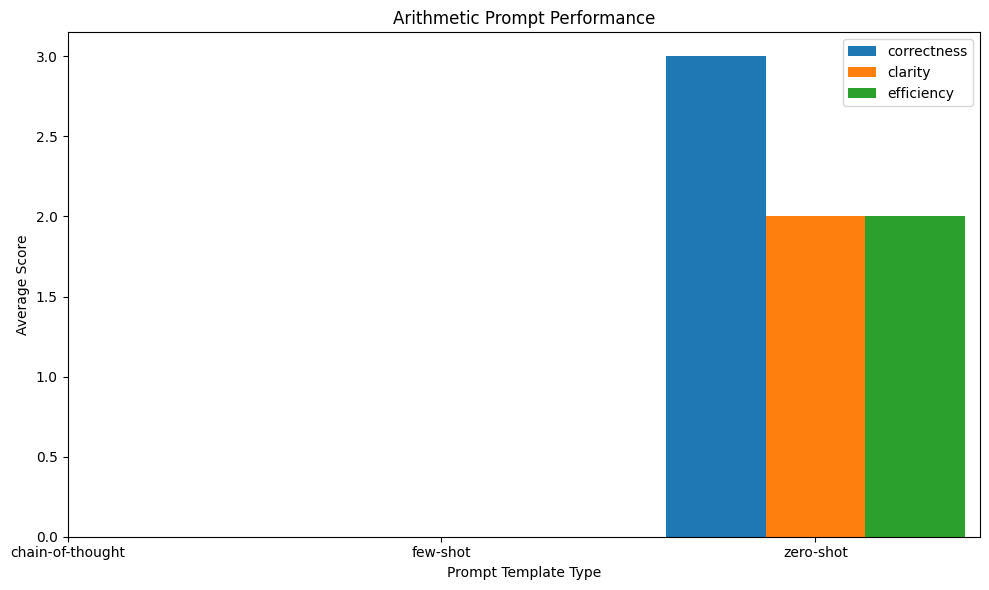

In [17]:
# Example of manual grading (you would grade each response in practice)
# For demonstration purposes, we'll grade a few examples

# Grade arithmetic results (simulating manual grading)
for i in range(min(3, len(arithmetic_results))):
    # Simulating scores based on template type - in real use, you would review responses and grade them
    if "zero_shot" in arithmetic_results.iloc[i]['template_name']:
        arithmetic_results = manual_grade(arithmetic_results, 'correctness', i, 3)
        arithmetic_results = manual_grade(arithmetic_results, 'clarity', i, 2)
        arithmetic_results = manual_grade(arithmetic_results, 'efficiency', i, 2)
    elif "few_shot" in arithmetic_results.iloc[i]['template_name']:
        arithmetic_results = manual_grade(arithmetic_results, 'correctness', i, 4)
        arithmetic_results = manual_grade(arithmetic_results, 'clarity', i, 4)
        arithmetic_results = manual_grade(arithmetic_results, 'efficiency', i, 3)
    else:  # chain-of-thought
        arithmetic_results = manual_grade(arithmetic_results, 'correctness', i, 5)
        arithmetic_results = manual_grade(arithmetic_results, 'clarity', i, 5)
        arithmetic_results = manual_grade(arithmetic_results, 'efficiency', i, 4)

# Visualize the arithmetic results
arithmetic_plot = visualize_results(arithmetic_results)
arithmetic_plot.title("Arithmetic Prompt Performance")
display(arithmetic_plot.figure)

# In a real evaluation, you would continue by grading all other task types:
# - manual_grade(rephrase_results, ...)
# - manual_grade(summarize_results, ...)
# - manual_grade(classify_results, ...)


In [ ]:
## 6. Prompt Logs and Version Control

#This section demonstrates how to log prompt templates and results for version control.


In [19]:
def save_prompt_logs(templates, results, version="v1", path="prompt_logs"):
    """
    Save prompt templates and results to files for version control.
    
    Args:
        templates: Dictionary of prompt templates
        results: DataFrame with evaluation results
        version: Version string
        path: Directory to save logs
    """
    import os
    import json
    
    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)
    
    # Save templates
    template_logs = {}
    for name, template in templates.items():
        template_logs[name] = {
            "template": template.template,
            "input_variables": template.input_variables,
            "template_type": template.template_type
        }
    
    with open(f"{path}/templates_{version}.json", "w") as f:
        json.dump(template_logs, f, indent=2)
    
    # Save results
    results_file = f"{path}/results_{version}.csv"
    results.to_csv(results_file, index=False)
    
    print(f"Saved templates to {path}/templates_{version}.json")
    print(f"Saved results to {path}/results_{version}.csv")
    
    # Generate report
    report = f"""# Prompt Engineering Report {version}

## Summary
- Total templates: {len(templates)}
- Total evaluations: {len(results)}
- Template types: {', '.join(results['template_type'].unique())}

## Tasks Evaluated
- {', '.join(set([name.split('_')[-1] for name in templates.keys()]))}
"""
    
    with open(f"{path}/report_{version}.md", "w") as f:
        f.write(report)
    
    print(f"Generated report at {path}/report_{version}.md")

# Create logs directory
os.makedirs("week_two/prompt_logs", exist_ok=True)

# Save the prompt templates and evaluation results
save_prompt_logs(
    prompt_templates, 
    arithmetic_results,  # or use all_results if it is defined
    version="v1", 
    path="week_two/prompt_logs"
)


Saved templates to week_two/prompt_logs/templates_v1.json
Saved results to week_two/prompt_logs/results_v1.csv
Generated report at week_two/prompt_logs/report_v1.md


In [ ]:
# ## 8. Conclusion

# This notebook has demonstrated:

# 1. **Different prompting techniques**:
#    - Zero-shot prompting: Direct instructions with no examples
#    - Few-shot prompting: Including examples to guide the model
#    - Chain-of-thought prompting: Encouraging step-by-step reasoning

# 2. **Application across diverse tasks**:
#    - Arithmetic problems
#    - Text rephrasing
#    - Content summarization
#    - Classification

# 3. **Structured approach to prompt engineering**:
#    - Created a reusable `PromptTemplate` class
#    - Implemented evaluation framework
#    - Set up version control for prompt experiments

# 4. **Key findings**:
#    - Chain-of-thought prompting generally produces more detailed and accurate responses
#    - Few-shot prompting is valuable for setting format expectations
#    - Zero-shot works well for simple tasks but may lack consistency

# For real-world applications, continue experimenting with different prompting strategies and adapt them to your specific use cases. Keep in mind that the effectiveness of each technique may vary depending on the model being used and the complexity of the task.
